Name: Aditri Jain
Assignment Dataset: Enron dataset

In [1]:
import re
import numpy as np # linear algebra
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


In [2]:
test_df=pd.read_csv('azureml://subscriptions/1e06577f-78ae-48c8-8dd1-a55dc756b867/resourcegroups/aditri/workspaces/Code_W_B/datastores/workspaceblobstore/paths/UI/2024-05-30_150256_UTC/emails.csv') #URI path to dataset

In [3]:
# Display the first few rows of the DataFrame
print(test_df.head())

# Get an overview of the DataFrame structure
print("dataset info: ")
print(test_df.info())

# Get summary statistics of the DataFrame
print(test_df.describe())

# Check for missing values in the DataFrame
print(test_df.isnull().sum())

# Display the first 500 entries of the 'file' column
print(test_df.file.head(500)) #The 'file' column seems to be an identifier or a path to the email file. It does not provide meaningful information for text analysis or machine learning tasks.

# Drop the 'file' column from the DataFrame
test_df.drop('file', axis=1, inplace=True)

# Split the first message to see its structure and different columns like message_ID, Date, From, To, Subject etc.
print(list(test_df.loc[0])[0].split('\n'))


                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...
dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB
None
                         file  \
count                  517401   
unique                 517401   
top     allen-p/_sent_mail/1.   
freq                        1   

                                      

In [6]:
# Function to extract metadata from the email message
def extract_metadata(message):
    headers = {}
    lines = message.split('\n')
    body_index = 0

    # Define a list of common header fields
    header_fields = {'Message-ID', 'Date', 'From', 'To', 'Subject', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding', 'X-From', 'X-To', 'X-cc', 'X-bcc', 'X-Folder', 'X-Origin', 'X-FileName'}

    # Loop through the lines to extract header fields
    for i, line in enumerate(lines):
        if ':' in line:
            key, value = line.split(':', 1)
            if key.strip() in header_fields:
                headers[key.strip()] = value.strip()
                body_index = i
            else:
                break
        else:
            break

    return headers

# Function to clean the email body text
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  # Remove single characters from start
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Replace multiple spaces with a single space
    text = re.sub(r'^b\s+', '', text)  # Remove prefixed 'b'
    text = text.lower()  # Convert to lowercase
    return text

# Function to extract the body of the email from the message
def extract_email_body(message):
    try:
        body = message.split('\n\n', 1)[1]  # Split based on the first double newline
    except IndexError:
        body = message  # If no double newline, take the entire message
    return body

# Set of stop words to exclude from the text
stop_words = set(ENGLISH_STOP_WORDS)
custom_stop_words = {"original", "message", "from", "subject", "com", "ect", "hou", "recipient"}
stop_words.update(custom_stop_words)

# Function to preprocess the text by tokenizing and removing stop words
def preprocess_text(text):
    tokens = re.findall(r'\b\w+\b', text.lower())  # Find all words and convert to lowercase
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return ' '.join(tokens)

# Function to preprocess the folder names
def preprocess_folder(data):
    folders = []
    for item in data:
        if item is None or item == '':
            folders.append(np.nan)
        else:
            item = item.split("\\")[-1]
            item = item.lower()
            folders.append(item)
    return folders      

# List of keywords commonly found in spam emails
spam_keywords = [
    'click below', 'click here', 'one hundred percent guaranteed', '50% off', 'unlimited', 'lottery', 'prize', 
    'claim', 'free', 'win', 'winner', 'congratulations', 'limited time', 'offer', 'discount', 'promotion', 
    'click here', 'buy now', 'urgent', 'money', 'guarantee', 'risk free', 'deal', 'save big', 'exclusive', 
    'clearance', 'cheap', 'bargain', 'bonus', 'no cost', 'double your', 'million', 'buy direct', 'clearance', 
    'make $', 'online degree', 'best price'
]

# Function to detect if an email is spam based on the presence of spam keywords
def is_spam(text):
    count = sum(keyword in text for keyword in spam_keywords)
    return count > 4

# Function to preprocess the entire dataset
def preprocess_new_data(df):
    # Extract and clean the email body text
    unwanted_folders = ["all documents", "deleted items", "discussion threads", "sent", "deleted Items", "inbox",
                   "sent items", "'sent mail", "untitled", "notes inbox", "calendar"]
    df['cleaned_body'] = df['message'].apply(lambda x: clean_text(extract_email_body(x)))
    df['processed_message'] = df['cleaned_body'].apply(preprocess_text)
    metadata = df['message'].apply(extract_metadata)
    metadata_df = pd.DataFrame(metadata.tolist())
    df = pd.concat([df, metadata_df], axis=1)
    df.fillna('', inplace=True)
    df['X-Folder'] = preprocess_folder(df['X-Folder'])
    df.fillna('', inplace=True)
    temp = ~df['X-Folder'].isin(unwanted_folders)
    filtered_df = df.loc[temp].copy()
    df['category'] = filtered_df['X-Folder']
    df['category'].dropna(inplace=True)
    df['is_spam'] = df['processed_message'].apply(is_spam)
    df.fillna('', inplace=True)
    return df

# Function to categorize emails based on the folder names and spam detection
def categorize_label(row):
    file_name = row['X-Folder'].lower()
    if row['is_spam']:
        return 'Spam'
    elif any(word in file_name for word in ['junk file','junk','motley fool e-mails','junk e-mail']):
        return 'Spam'
    elif any(word in file_name for word in['resume','application','interviews','recruiting']):
        return 'Recruiting'
    elif any(word in file_name for word in ['universities','mba program','stanford','mba--e-commerce','analyst prog']):
        return 'Programs'
    elif any(word in file_name for word in['meeting','conference','presentations','meetings - tw customer']):
        return 'Meetings'
    elif any(word in file_name for word in['hr','human resources','netco hr']):
        return 'HR'
    elif any(word in file_name for word in['enron news', 'corporate comm','enron t&s','corp info_announcements','corp info/announcements','organizational changes','organizational issues','org announc. & chrts','policy','corp memos','restructuring','organizational announcements','org. announc.','newsletter']):
        return 'Announcements'
    elif any(word in file_name for word in ['genco-jv_ipo','receipts','deal discrepancies','online trading','ctg-deals','iso_ pricecaps','ca refunds','asset marketing','finance','bankrupt','fin desk','credit issues','budget','trading info','2001 budget','finanial operations','trading issues','s.a. trading','accounting','expense reports']):
        return 'Finance'
    elif any(word in file_name for word in ['savedmail', 'saved mail', 'personal', 'contacts','to do','myfriends','personal mail','quotes','tasks','personalfolder','congratulations','personal stuff','church','humor','social','family','save the date','friends','funny','compliments','pictures','daily blessings','personal contacts','to do list','stuff','fun','fun emails','personal files']):
        return 'Personal'
    elif any(word in file_name for word in ['tasks', 'memo', 'press releases', 'straw','info' ,'logistics','corporate','management','market','projects','personnel','_exchange_info','work mail']):
        return 'Work'
    elif any(word in file_name for word in ['california', 'vanderbilt', 'universal studios','portland','europe','canada','yazoo city','denver','australia','mexico','japan','london','india','chicago','florida','brazil','dublin','california - working group','chicago office','paris','pasadena','italy','argentina','guatemala']):
        return 'Locations'
    elif any(word in file_name for word in ['bmc', 'fedex', 'sony', 'dell', 'hp', 'ge', 'avaya', 'compaq','ces','it','wordsmith']):
        return 'Technology'
    else:
        return 'Other'


In [7]:
# Preprocess the new data
test_df = preprocess_new_data(test_df)

In [8]:
# Print the first few rows of the DataFrame to check the kind of values in the dataset
print(test_df.head())

# Print the list of columns in the DataFrame
print(list(test_df))

# Check for NA values in the DataFrame
print(test_df.isna().sum())

# Print unique values in the 'Mime-Version' column
print(test_df['Mime-Version'].unique())

# Print unique values in the 'Content-Transfer-Encoding' column
print(test_df['Content-Transfer-Encoding'].unique())

# Print unique values in the 'Content-Type' column
print(test_df['Content-Type'].unique())

# Drop irrelevant columns from the DataFrame
test_df.drop(['message','Mime-Version','Content-Type','X-From','Content-Transfer-Encoding','X-To','X-cc','X-bcc','X-FileName','X-Origin'], axis=1, inplace=True)

# Fill empty spaces with an empty string
test_df.fillna('', inplace=True)

# Print the counts of different categories in the 'category' column
print(test_df.category.value_counts())

# Save the category counts to a CSV file for easier viewing (not shown in code but implied by the comment)
test_df.category.value_counts()


                                             message  \
0  Message-ID: <18782981.1075855378110.JavaMail.e...   
1  Message-ID: <15464986.1075855378456.JavaMail.e...   
2  Message-ID: <24216240.1075855687451.JavaMail.e...   
3  Message-ID: <13505866.1075863688222.JavaMail.e...   
4  Message-ID: <30922949.1075863688243.JavaMail.e...   

                                        cleaned_body  \
0                              here is our forecast    
1  traveling to have business meeting takes the f...   
2                         test successful way to go    
3  randy can you send me schedule of the salary a...   
4                    let shoot for tuesday at 11 45    

                                   processed_message  \
0                                           forecast   
1  traveling business meeting takes fun trip espe...   
2                                test successful way   
3  randy send schedule salary level scheduling gr...   
4                            let shoot tuesday

category
                               486853
personal                         1897
meetings                         1738
attachments                       812
deal discrepancies                810
                                ...  
inland                              1
training - business objects         1
supply chain                        1
tw - invoicing                      1
nrg                                 1
Name: count, Length: 1432, dtype: int64

In [9]:
test_df['label'] = test_df.apply(categorize_label, axis=1)

In [10]:
# Create a mapping from unique labels to numeric indices
label_mapping = {label: idx for idx, label in enumerate(test_df['label'].unique())}

# Map the labels in the DataFrame to the corresponding numeric indices
test_df['label_encoded'] = test_df['label'].map(label_mapping)

# Extract the encoded labels as the target variable
y = test_df['label_encoded']

# Combine 'processed_message', 'Subject', and 'X-Folder' columns to form the text data
vectorizer = CountVectorizer(max_features=150000)  

# Fit the vectorizer on the combined text data and transform the text into numerical features
X = vectorizer.fit_transform(test_df['processed_message'] + " " + test_df['Subject'] + " " + test_df['X-Folder'])


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler = StandardScaler(with_mean=False)  # with_mean=False to work with sparse matrix
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Logistic Regression model with 'saga' solver
model = LogisticRegression(max_iter=5000, solver='saga', tol=1e-3)

params = {'C': [1, 10]}
grid = GridSearchCV(model, params, cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# Get the best estimator
best_estimator = grid.best_estimator_
print(f"Best params for LogisticRegression: {grid.best_params_}")

# Evaluate the best estimator on the test set
test_score = best_estimator.score(X_test_scaled, y_test)
print(f"Test set accuracy: {test_score:.4f}")

y_pred = best_estimator.predict(X_test_scaled)
test_score = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {test_score:.4f}")

Best params for LogisticRegression: {'C': 10}
Test set accuracy: 0.9251
Test set accuracy: 0.9251


In [12]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted',zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted',zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted',zero_division=1)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.93
Precision: 0.92
Recall: 0.93
F1 Score: 0.92


Classification Report:
                precision    recall  f1-score   support

        Other       0.93      0.98      0.95     78706
         Spam       0.89      0.79      0.84      2395
     Personal       0.72      0.11      0.19       789
   Technology       0.89      0.79      0.83     13157
           HR       0.97      0.84      0.90      6660
         Work       0.64      0.10      0.17       472
     Meetings       0.93      0.79      0.86       416
    Locations       0.50      0.02      0.04       241
      Finance       0.88      0.31      0.46       340
   Recruiting       0.25      0.01      0.02        90
Announcements       0.87      0.07      0.14       175
     Programs       0.00      0.00      0.00        40

     accuracy                           0.93    103481
    macro avg       0.70      0.40      0.45    103481
 weighted avg       0.92      0.93      0.92    103481



<Figure size 1000x700 with 0 Axes>

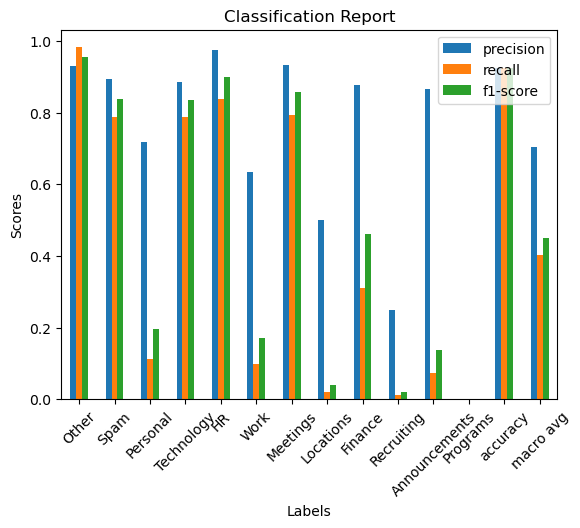

In [13]:
class_report = classification_report(y_test, y_pred, target_names=[str(label) for label in label_mapping.keys()])
print('Classification Report:\n', class_report)

# Plot the Classification Report
report = classification_report(y_test, y_pred, target_names=[str(label) for label in label_mapping.keys()], output_dict=True)
df_class_report = pd.DataFrame(report).transpose()

# Plotting Precision, Recall, and F1-Score
plt.figure(figsize=(10, 7))
df_class_report.iloc[:-1, :-1].plot(kind='bar')
plt.title('Classification Report')
plt.ylabel('Scores')
plt.xlabel('Labels')
plt.xticks(rotation=45)
plt.show()